# Post-clustering tasks
This notebook allows the user to inspect and fine-tune the output of the [clustering](https://github.com/angelolab/ark-analysis/blob/main/templates_ark/3_Cluster_Cells.ipynb) notebook. There are two parts of this notebook. 
1. Clustering cleanup: If there are clusters that were not properly separated during Pixie cell clustering, this provides the option of defining manual thresholds based on marker intensity to combine or separate specific clusters
2. Marker thresholding: For markers that were not directly used for clustering, but whose expression is important for phenotyping individual cells, this provides the user with visualization to determine accurate thresholds for positive/negative classification

In [1]:
# import needed libraries
import os

import numpy as np
import pandas as pd

from ark.phenotyping.post_cluster_utils import create_mantis_project, plot_hist_thresholds
from ark.utils.data_utils import download_example_data

### Download the Example Dataset

Run the cell below in order to work with the example dataset if it's been downloaded from Notebook 1: Segment Image Data.

*Note:* If you have already ran this step in the previous notebook, it will not download it again unless there are updates to the dataset.

In [ ]:
example_dataset_path = download_example_data("../data/")

## 0. Set variables
* `testing_fovs`: a list of FOVs to use for evaluating the post-clustering tasks
* `base_dir`: the path to all of your imaging data. Should be the same one used for the [cell clustering notebook](https://github.com/angelolab/ark-analysis/blob/main/templates_ark/3_Cluster_Cells.ipynb)
* `cell_output_dir`: the path to the directory used for cell clustering
* `cell_table_name`: the name of the cell table containing the cluster labels
* `segmentation_dir`: the path to the directory containing the segmentation masks
* `image_dir`: the path to the directory containing the image data

In [3]:
# FOVs that will be used to evaluate accuracy
testing_fovs = ['fov0', 'fov1']

# paths
base_dir = '../data/example_data/'
cell_output_dir = os.path.join(base_dir, 'example_cell_output_dir')
cell_table_name = 'combined_cell_table_normalized_cell_labels.csv'
segmentation_dir = os.path.join(base_dir, 'segmentation/deepcell_output')
tiff_dir = os.path.join(example_dataset_path, "input_data")

The following directories will be automatically created without any user input required

In [4]:
# create directory to hold outputs
post_cluster_dir = os.path.join(base_dir, 'post_clustering')
if not os.path.exists(post_cluster_dir):
    os.makedirs(post_cluster_dir)
    
# create directory to hold mantis masks
mask_dir = os.path.join(post_cluster_dir, 'masks')
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# create directory to hold full mantis output
mantis_dir = os.path.join(post_cluster_dir, 'mantis')
if not os.path.exists(mantis_dir):
    os.makedirs(mantis_dir)
    
# read in cell table
cell_table =  pd.read_csv(os.path.join(cell_output_dir, cell_table_name))

## 1. Clustering Cleanup
You may have noticed during the cell clustering process that certain populations need to be modfified/adjusted. This part of the notebook allows you to identify proportions of a given cell population to be reassigned to a different one. 

### Identify thresholds for splitting problematic clusters
The cell below will plot a histogram of marker expression across multiple cell population. This is useful for identifying an aproximate threshold which separates positive from negative expression. The first population(s) should be positive for the marker, with the subsequent populations negative. This can be then be used to pull out the subset of cells which express a given marker, but shouldn't, from an individual population

* `populations`: list of clustering populations to use for plotting
* `marker`: the channel whose expression will be used to determine problematic cells
* `threshold`: value that will be plotted with a vertical line for visualization purposes to aid identification of the correct value

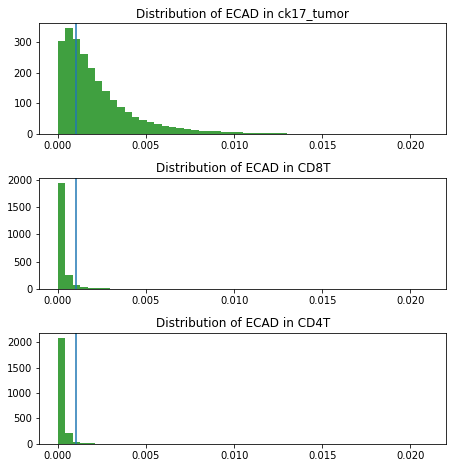

In [5]:
# This cell can be re-run to identify different thresholds and different populations that need adjusting
populations = ['ck17_tumor', 'CD8T', 'CD4T']
marker = 'ECAD'
threshold = 0.001

plot_hist_thresholds(cell_table=cell_table, populations=populations, marker=marker, threshold=threshold)

### Splitting problematic clusters
Once you have an identified a threshold which does a good job of separating negative from positive cells, that threshold can be used to pull out specific cells from a population and reassign them. For example, the cell below identifies CD8T cells which express ECAD, and assigns them to a new population for manual inspection. You'll need to specify the following parameters:
* `marker`: the marker used for separating cells, the same one that was used to generate the histograms above
* `threshold`: the threshold for separating cells, can be identified using the threshold argument above or by visual inspection
* `target_cluster`: the name of the cell_cluster that contains the contamination
* `problematic_cluster`: the name of the new population that will be created based on the threshold

This process of identifying thresholds and creating new populations can be repeated for each population where a problem was identified during the clustering process. We recommend making a copy of the cell below for each modification so that you have a record of what changes were made. 

In [4]:
# The plots above indicate that 0.001 is a reasable threshold for separating ECAD+ cells. 
marker = 'ECAD'
threshold = 0.001
target_cluster = 'CD8T'
problematic_cluster = 'CD8T_ECAD_high'

# determine logic for thresholding; e.g. marker > threshold, marker <= threshold, or alternative logic
selected_idx = cell_table[marker] > threshold

# Create new column in cell table based on above
cell_table.loc[np.logical_and(cell_table['cell_meta_cluster'] == target_cluster, selected_idx), 'cell_meta_cluster'] = problematic_cluster

### Manual inspection of problematic clusters with Mantis
Once you've pulled out the problematic cells into new clusters, you'll need to visually inspect them to determine which cluster they belong to. The code below will create a directory to enable easy visualization with Mantis Viewer. See the [Mantis section of the README](../README.md#mantis-viewer) for an overview of how to use Mantis. You can then manually inspect each of the newly created clusters to determine what the true cell type is.

In [12]:
# create directory that can be read into Mantis
create_mantis_project(cell_table=cell_table, fovs=testing_fovs[1:], seg_dir=segmentation_dir, pop_col='cell_cluster', mask_dir=mask_dir,
                          mantis_dir=mantis_dir, image_dir=image_dir)

### Determine final cluster assignment
Once you've inspected each of the clusters, you'll need to decide what their final assignment should be. You can either merge them back in with their original cluster, combine them with a different existing cluster, or create a new cluster, depending on what you found after manual inspection.

In [6]:
# set names of problematic cluster and new cluster
problematic_cluster = 'CD8T_ECAD_high'
final_assignment = 'tumor'

# assign problematic cluster new name
cell_table.loc[cell_table['cell_meta_cluster'] == problematic_cluster, 'cell_meta_cluster'] = final_assignment

In [7]:
# Save the updated cell table
cell_table.to_csv(os.path.join(post_cluster_dir, 'updated_cell_table.csv'))

## 2. Marker thresholding
For markers like Ki67 or PD1, we generally don't include them in the clustering process. Intead, following clustering, we score each cell as positive or negative for these "functional markers." This requires picking a threshold for each marker to determine positivity and negativity. Looking directly at the histograms can be useful for getting a general range for where the threshold lies, but picking a specific threshold based only on the histogram can be challenging. Instead, what is often most useful is simply looking at images to determine the specific cutoff value.

### Set up variables
To evaluate the marker levels, we use the modified cell table from the previous step. In addition, we select which markers need to be thresholded

In [6]:
# load modified cell table
cell_table = pd.read_csv(os.path.join(post_cluster_dir, 'updated_cell_table.csv'))

# specify functional markers that need to be thresholded
functional_markers = ['PD1', 'Ki67', 'GLUT1']

### Create Mantis project with functional marker counts
To identify the appropriate threshold, we will include the counts of the markers in the mantis directory. The code below will include the specified functional markers for mantis to view

In [15]:
# create directory that can be read into Mantis
create_mantis_project(cell_table=cell_table, fovs=testing_fovs, seg_dir=segmentation_dir, pop_col='cell_meta_cluster', mask_dir=mask_dir,
                      mantis_dir=mantis_dir, image_dir=tiff_dir)

# create dataframe with counts of the specified markers
marker_counts_df = cell_table.loc[np.isin(cell_table['fov'], testing_fovs), ['fov', 'label'] + functional_markers]

# save dataframe
marker_counts_df.to_csv(os.path.join(mantis_dir, 'marker_counts.csv'), index=False)

### Identify plausible range for a given marker threshold
To get a rough idea of what range works for a given functional marker, we can plot its expression across cell types that we do, and do not, expect to be positive for it

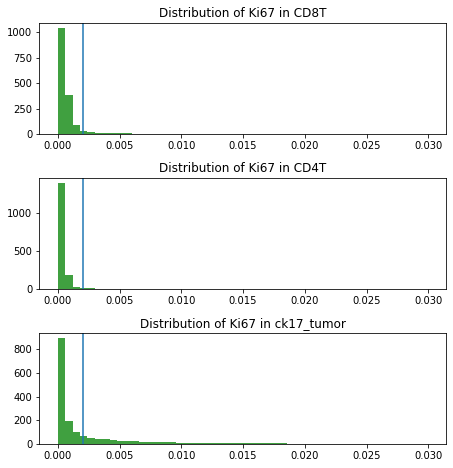

In [10]:
# This cell can be re-run to identify different thresholds across different functional markers
populations = ['CD8T', 'CD4T', 'ck17_tumor']
marker = 'Ki67'
threshold = 0.002

plot_hist_thresholds(cell_table=cell_table, populations=populations, marker=marker, threshold=threshold)

### Manually inspect images to confirm
Once you've identified a plausible threshold for the specified marker, it's time to look at the images in Mantis. In each image, identify the cells that are positive for the specified marker, and determine what their expression level is. Then, do the same thing for the cells that are negative for the marker. By performing this across a representative range of images, it is straightforward to come up with an estimate of what threshold accurately descriminates between positive and negative cells. You'll need to first [load the marker_counts.csv file](../README.md#loading_project_wide_files) into Mantis. Then, once it's been loaded, you can [view the expression](../README.md#view_cell_features) of the specified marker for the cells in the image. 

### Record threshold values
After manual inspection, you'll need to record the value you selected as a threshold for each marker. Fill in the list below with the values you selected, adding additional brackets as necessary for all of the markers you wish to annotate

In [13]:
# create list to hold all functional marker, value pairs
threshold_list = [['PD1', 0.0005], ['Ki67', 0.002], ['GLUT1', 0.002]]

### Update cell table
Finally, you'll update your cell table with the thresholded values. The code below will add a new column named `{marker}_threshold` for each of the indicated marker, with a value of `True` if it's greater than or equal to the threshold, and a value of `False` otherwise.

In [14]:
# add columns to cell table
for marker, threshold in threshold_list:
    cell_table[marker + '_threshold'] = cell_table[marker].values >= threshold

# save thresholded cell table
cell_table.to_csv(os.path.join(post_cluster_dir, 'cell_table_thresholded.csv'))